In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 86043517.19it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119817699.13it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25278489.54it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3137955.65it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
#Linear GAN
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


In [ ]:
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):

    D.zero_grad()

    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output


    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [ ]:
def G_train(x):

    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [ ]:
n_epoch = 20
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: DIscriminator Loss: %.4f, Generator Loss: %.4f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/20]: DIscriminator Loss: 0.6532, Generator Loss: 2.2837
[2/20]: DIscriminator Loss: 0.6708, Generator Loss: 2.3546
[3/20]: DIscriminator Loss: 0.6677, Generator Loss: 2.2851
[4/20]: DIscriminator Loss: 0.7403, Generator Loss: 2.1221
[5/20]: DIscriminator Loss: 0.7216, Generator Loss: 2.1381
[6/20]: DIscriminator Loss: 0.7808, Generator Loss: 1.9058
[7/20]: DIscriminator Loss: 0.8123, Generator Loss: 1.8337
[8/20]: DIscriminator Loss: 0.8191, Generator Loss: 1.8162
[9/20]: DIscriminator Loss: 0.8566, Generator Loss: 1.6941
[10/20]: DIscriminator Loss: 0.9008, Generator Loss: 1.5936
[11/20]: DIscriminator Loss: 0.9644, Generator Loss: 1.5187
[12/20]: DIscriminator Loss: 0.9010, Generator Loss: 1.6222
[13/20]: DIscriminator Loss: 0.9061, Generator Loss: 1.6131
[14/20]: DIscriminator Loss: 0.9335, Generator Loss: 1.5267
[15/20]: DIscriminator Loss: 0.9752, Generator Loss: 1.4808
[16/20]: DIscriminator Loss: 0.9818, Generator Loss: 1.4460
[17/20]: DIscriminator Loss: 0.9900, Generator Lo

In [ ]:
z = Variable(torch.randn(bs, z_dim).to(device))
G_output = G(z)

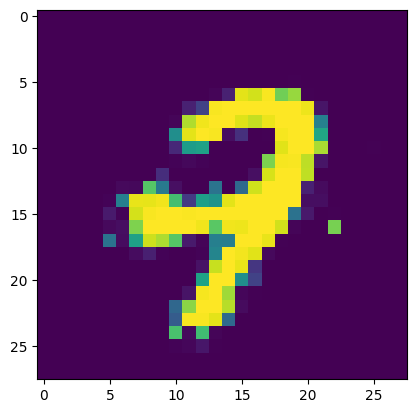

In [ ]:
plt.imshow(G_output[9].cpu().detach().numpy().reshape(28, 28))


###  Conditional GAN (cGAN)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()

        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [ ]:
num_epochs = 20
n_critic = 5
display_step = 50
batch_size = 50
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        step = epoch * len(train_loader) + i + 1
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()

        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)


        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).to(device)
            labels = Variable(torch.LongTensor(np.arange(9))).to(device)
            sample_images = generator(z, labels).unsqueeze(1)

    print('Epoch = ',epoch,'d_loss =', d_loss,'g_loss = ',g_loss)

Epoch =  0 d_loss = 0.00018834018555935472 g_loss =  10.236160278320312
Epoch =  1 d_loss = 0.0001970434677787125 g_loss =  11.652363777160645
Epoch =  2 d_loss = 0.03332867845892906 g_loss =  10.899397850036621
Epoch =  3 d_loss = 0.004091085400432348 g_loss =  10.750921249389648
Epoch =  4 d_loss = 0.03166554123163223 g_loss =  8.031506538391113
Epoch =  5 d_loss = 0.009119308553636074 g_loss =  8.916341781616211
Epoch =  6 d_loss = 0.003801006358116865 g_loss =  10.52273178100586
Epoch =  7 d_loss = 0.0808638259768486 g_loss =  7.91674280166626
Epoch =  8 d_loss = 0.052711375057697296 g_loss =  9.743026733398438
Epoch =  9 d_loss = 0.029016144573688507 g_loss =  7.650644779205322
Epoch =  10 d_loss = 0.11252361536026001 g_loss =  7.214284420013428
Epoch =  11 d_loss = 0.013977468013763428 g_loss =  9.599370956420898
Epoch =  12 d_loss = 0.08275267481803894 g_loss =  6.639179706573486
Epoch =  13 d_loss = 0.24040983617305756 g_loss =  6.013957977294922
Epoch =  14 d_loss = 0.09243917

In [ ]:
z = Variable(torch.randn(batch_size, 100)).to(device)
fake_labels = Variable(torch.LongTensor(np.random.randint(5, 6, batch_size))).to(device)
fake_images = generator(z, fake_labels)

In [ ]:
fake_labels[2]

tensor(5, device='cuda:0')

Label =  5


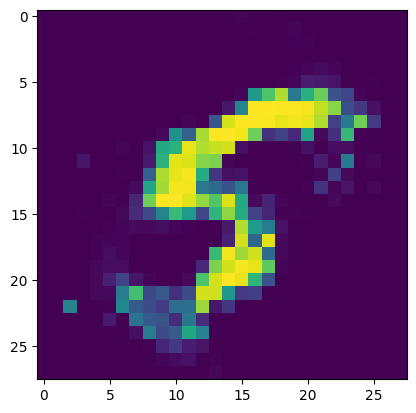

In [ ]:
print('Label = ',int(fake_labels[2]))
plt.imshow(fake_images[2].cpu().detach().numpy())